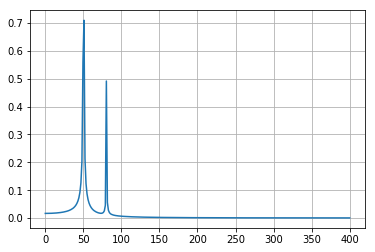

In [3]:
from scipy.fftpack import fft
import numpy as np
# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N/2]))
plt.grid()
plt.show()

In [ ]:
from scipy.io.wavfile import read, write
from scipy.signal import find_peaks_cwt, firwin, lfilter, medfilt, resample, hamming
from scipy.optimize import fmin
import numpy as np
from matplotlib import pyplot as plt

import argparse


class Tone:
    def __init__(self, begin_time=0.0, end_time=0.0, harmonics=None):
        # Unreadable but quick, cheap & dirty trick
        self.__dict__.update(**locals())

    def __repr__(self):
        return "{begin_time}-{end_time}: {sorted_harmonics}".format(
            sorted_harmonics=sorted(self.harmonics.items()),
            **self.__dict__
        )


def getTones(data, rate):
    """Get list of tones recognized in the data array."""
    norm_data = data.astype('double') / ( 2 ** 15 - 1)
    x_axis = np.arange(len(norm_data)) / rate

    Pxx, ori_freqs, t, x = plt.specgram(data, NFFT=1024, noverlap=0, Fs=rate)

    tones = []
    for blk_idx in range(len(Pxx[0])):

        fft_block = np.array(list(zip(*Pxx))[blk_idx])[:60]
        fft_block, freqs = resample(fft_block, 10*len(fft_block), ori_freqs[:60], window='hamming')
        # Find peaks
        peak_idx = find_peaks_cwt(fft_block[:len(fft_block)/1.8], np.arange(3, 20))
        peak_idx = np.array(peak_idx)
        if len(peak_idx) and np.max(fft_block[peak_idx]) > 100.0:
            tone = Tone(
                blk_idx * 512 / 44100.0,
                ((blk_idx + 1) * 512 - 1) / 44100.0,
                { freqs[freq]: fft_block[freq] for freq in peak_idx },
            )
            tones.append(tone)

    return tones

def mergeTones(tones, freqThr=0.06):
    if not tones:
        return []

    main_harm = lambda x: max(x.harmonics.items(), key=lambda y: y[1])
    main_freq = lambda x: float(main_harm(x)[0])
    retVal = [tones[0]]
    for tone in tones[1:]:
        # If frequencies in both signals are near and proeminent
        for harm_freq, harm_ampli in tone.harmonics.items():
            near_powerful = harm_ampli > 0.5 * main_harm(retVal[-1])[1]
            if not near_powerful:
                continue
            pdiff = abs(main_freq(retVal[-1]) - harm_freq) / main_freq(retVal[-1])
            same_tone = pdiff < freqThr
            if same_tone:
                retVal[-1].end_time = tone.end_time
                break
        else:
            retVal.append(tone)

    return retVal

def decodeDTMF(tones):
    DTMF = {
        '1': (697, 1209),
        '2': (697, 1336),
        '3': (697, 1477),
        '4': (770, 1209),
        '5': (770, 1336),
        '6': (770, 1477),
        '7': (852, 1209),
        '8': (852, 1336),
        '9': (852, 1477),
        '*': (941, 1209),
        '0': (941, 1336),
        '#': (941, 1477),
    }
    retVal = []
    for tone in tones:
        # Get the two maximum frequencies of the tone
        freqs = sorted(tone.harmonics.items(), key=lambda x: -x[1])[:2]
        # Re-order by frequency
        freqs = sorted(x[0] for x in freqs)
        distance = float('inf')
        this_symbol = 'X'
        for symbol, ref_freqs in DTMF.items():
            # RSS
            this_error = (freqs[0] - ref_freqs[0])**2 + (freqs[1] - ref_freqs[1])**2
            if this_error < distance:
                distance = this_error
                this_symbol = symbol
        retVal.append(this_symbol)
        print(freqs)
    return retVal


if __name__ == '__main__':
    rate, data = read('dtmf.wav')
    tones = getTones(data, rate)
    out = mergeTones(tones)
    number = decodeDTMF(out)
    print(number)